# HiCExplorer using macaque data

## Reality check

### Conda environment

The notebook must be launched from the `hic` environment.

Check with the cell magic `%conda info` where the shell escape (`!` or `%%bash`) looks. 

### Kernel

***Before using this notebook, make sure to use the 'hic' kernel.*** 

I might change the env into a seperate HiC env for each of the tools, such as HICExplorer, Cooler/cooltools, etc. 

As of this version, there is only one environment in the repo, and it contains both Python, R, and CLI tools for use in HI-C data analysis. 


## Getting started with an overview

In this notebook, we will use HiCExplorer to analysis Hi-C reads from macaque monkeys. We will follow an [example](https://hicexplorer.readthedocs.io/en/latest/content/example_usage.html#how-we-use-hicexplorer) from the HiCExplorer documentation.

First, let's look at the files we have. They are from [SRA](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA430777&o=acc_s%3Aahttps://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA430777&o=acc_s%3Aa), and are Hi-C sequencing data from macaque fibroblasts. The data is generated for the Wang2019 paper. 

In [2]:
%%bash 

tree ../data/links/macaque_fastq

tree ../../../../data/macaque_raw/downloaded/

du -ha ../../../../data/macaque_raw/downloaded/*.gz


../data/links/macaque_fastq
├── SRR6502335_1.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502335_1.fastq.gz
├── SRR6502335_2.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502335_2.fastq.gz
├── SRR6502336_1.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502336_1.fastq.gz
├── SRR6502336_2.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502336_2.fastq.gz
├── SRR6502337_1.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502337_1.fastq.gz
├── SRR6502337_2.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502337_2.fastq.gz
├── SRR6502338_1.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502338_1.fastq.gz
├── SRR6502338_2.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502338_2.fastq.gz
├── SRR6502339_1.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502339_1.fastq.gz
└── SRR6502339_2.fastq.gz -> ../../../../../../data/macaque_raw/downloaded/SRR6502339_2.fastq.gz

0

### An overview of the sequences

We can see summary statistics for our sequences in the `SraRunTable.txt`

In [2]:
import pandas as pd

sra_runtable = pd.read_csv("../../../../data/macaque_raw/downloaded/SraRunTable.txt")
sra_runtable

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,...,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,cell_type,tissue,agent,genotype
0,SRR6502335,Hi-C,300,73201141800,PRJNA430777,SAMN08375237,31966430779,GEO,public,"fastq,run.zq,sra",...,2019-02-12T00:00:00Z,2018-01-23T23:05:00Z,1,GSM2940099,fibroblast,SRP131117,fibroblast,NaN,NaN,NaN
1,SRR6502336,Hi-C,300,65119970100,PRJNA430777,SAMN08375237,24433383054,GEO,public,"fastq,run.zq,sra",...,2019-02-12T00:00:00Z,2018-01-24T00:16:00Z,1,GSM2940099,fibroblast,SRP131117,fibroblast,NaN,NaN,NaN
2,SRR6502337,Hi-C,300,52769196300,PRJNA430777,SAMN08375236,23015357755,GEO,public,"fastq,run.zq,sra",...,2019-02-12T00:00:00Z,2018-01-24T07:21:00Z,1,GSM2940100,fibroblast,SRP131117,fibroblast,NaN,NaN,NaN
3,SRR6502338,Hi-C,300,52378949100,PRJNA430777,SAMN08375236,22999581685,GEO,public,"fastq,run.zq,sra",...,2019-02-12T00:00:00Z,2018-01-23T22:14:00Z,1,GSM2940100,fibroblast,SRP131117,fibroblast,NaN,NaN,NaN
4,SRR6502339,Hi-C,300,28885941600,PRJNA430777,SAMN08375236,10960123150,GEO,public,"fastq,run.zq,sra",...,2019-02-12T00:00:00Z,2018-01-23T21:03:00Z,1,GSM2940100,fibroblast,SRP131117,fibroblast,NaN,NaN,NaN


### Preparation of the `.fastq` files

The `.fastq` files were all prepared using this [workflow](../gwf_map_reads.py). Briefly, it does three things on the reference genome (Mmul_10/rheMac10): 

1. indexing with `bwa index`  
2. indexing with `samtools faidx` 
3. indexing of restriction sites of the used restriction enzyme used  (`hicFindRestSites`)

Then, it maps all the `.fastq` files (each mate individually) back to the reference genome with `bwa mem`. 

Finally, it builds the `.h5` Hi-C matrix with `hicBuildMatrix`, which includes some quality control of the Hi-C library. The results from the quality control can be viewed [here](../results/Readme.md).

But also, they are located in the `steps/` folder as a log, so let's read it into view:

# HiCExplorer begins

We wil use the `HicExplorer` commands in the following order:

- hicNormalize
- hicCorrectMatrix
    - diagnostic_plot
    - correct
- hicPlotMatrix

We already used `hicFindRestSites` and `hicBuildMatrix` commands from the *HicExplorer* tool. 

First, we will make a function to read the `.log` file into a `pandas` df. 

In [9]:
import pandas as pd
import glob

# All the files can be assigned to a list with glob.glob:
# logs = glob.glob("../results/SRR*/*.log")
# they can be read with a for loop, but it's too messy to show. 

# The .log file is a tab-separated file with 4 tables, so we have to make our own function to read it
# I wrapped it in a class to save all tables from each log in a single variable. 
class HiCQCLog(): 
    def __init__(self, logfile):
        reader = pd.read_csv(logfile, sep="\t", header=None, iterator=True)
        t1 = reader.get_chunk(4).dropna(axis=1)
        t1.columns=t1.iloc[0]
        self.t1 = t1.drop(0).reset_index()

        t2 = reader.get_chunk(6).dropna(axis=1)
        t2.columns=t2.iloc[0]
        self.t2 = t2.drop(4).reset_index()

        t3 = reader.get_chunk(7) .dropna(axis=1)
        t3.columns=t3.iloc[0]
        self.t3 = t3.drop(10).reset_index()

        t4 = reader.get_chunk(7).dropna(axis=1)
        t4.columns=t4.iloc[0]
        self.t4 = t4.drop(17).reset_index()
        
    def view(self):
        display(self.t1, self.t2, self.t3, self.t4)
  

In [24]:
# Make a function to plot .pngs with matplotlib

import os
import glob
import matplotlib.pyplot as plt
from PIL import Image

def plot_pngs_in_grid(image_folder, suffix=".png", ncol=3):
    """
    Plots all PNG images from a specified folder in a grid.
    
    Parameters:
    image_folder (str): Path to the folder containing the PNG files.
    num_cols (int): Number of columns in the grid layout. Default is 3.
    
    Returns:
    None
    """
    # Find all .png files in the folder
    # with a specified suffix (default: .png)
    print(f"Plotting all images in '{os.path.join(image_folder, f'*{suffix}')}'")
    image_files = glob.glob(os.path.join(image_folder, f'*{suffix}'))

    # If no images found, print a message and return
    if not image_files:
        print(f"No PNG files found in {image_folder}.")
        return
    
    # Calculate the number of rows needed
    num_cols = ncol
    num_images = len(image_files)
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    # Create a matplotlib figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten axes in case the grid is not a perfect rectangle
    axes = axes.flatten()

    # Loop through image files and plot them
    for i, image_file in enumerate(image_files):
        img = Image.open(image_file)  # Open the image file
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].set_title(os.path.basename(image_file))  # Set image title (filename)

    # Hide any remaining empty subplots if the number of images is not a perfect fit for the grid
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout to fit images and titles nicely
    plt.tight_layout()
    plt.show()


In [32]:
glob.glob(os.path.join("../steps/bwa/QC_all_samples/", f'*.png'))

['../steps/bwa/QC_all_samples/read_orientation.png',
 '../steps/bwa/QC_all_samples/distance.png',
 '../steps/bwa/QC_all_samples/pairs_discarded.png',
 '../steps/bwa/QC_all_samples/unmappable_and_non_unique.png',
 '../steps/bwa/QC_all_samples/pairs_sequenced.png']

## Results from `bwa`

In [ ]:
SRR35 = HiCQCLog("../results/SRR6502335_QC/QC.log")
SRR35.view()

In [18]:
!hicQC --logfiles $(echo ../results/*_QC/QC.log) --labels "SRR35" "SRR36" "SRR37" "SRR38" "SRR39" --outputFolder ../steps/bwa/QC_all_samples

Plotting all images in '../steps/bwa/QC_all_samples/*.png'


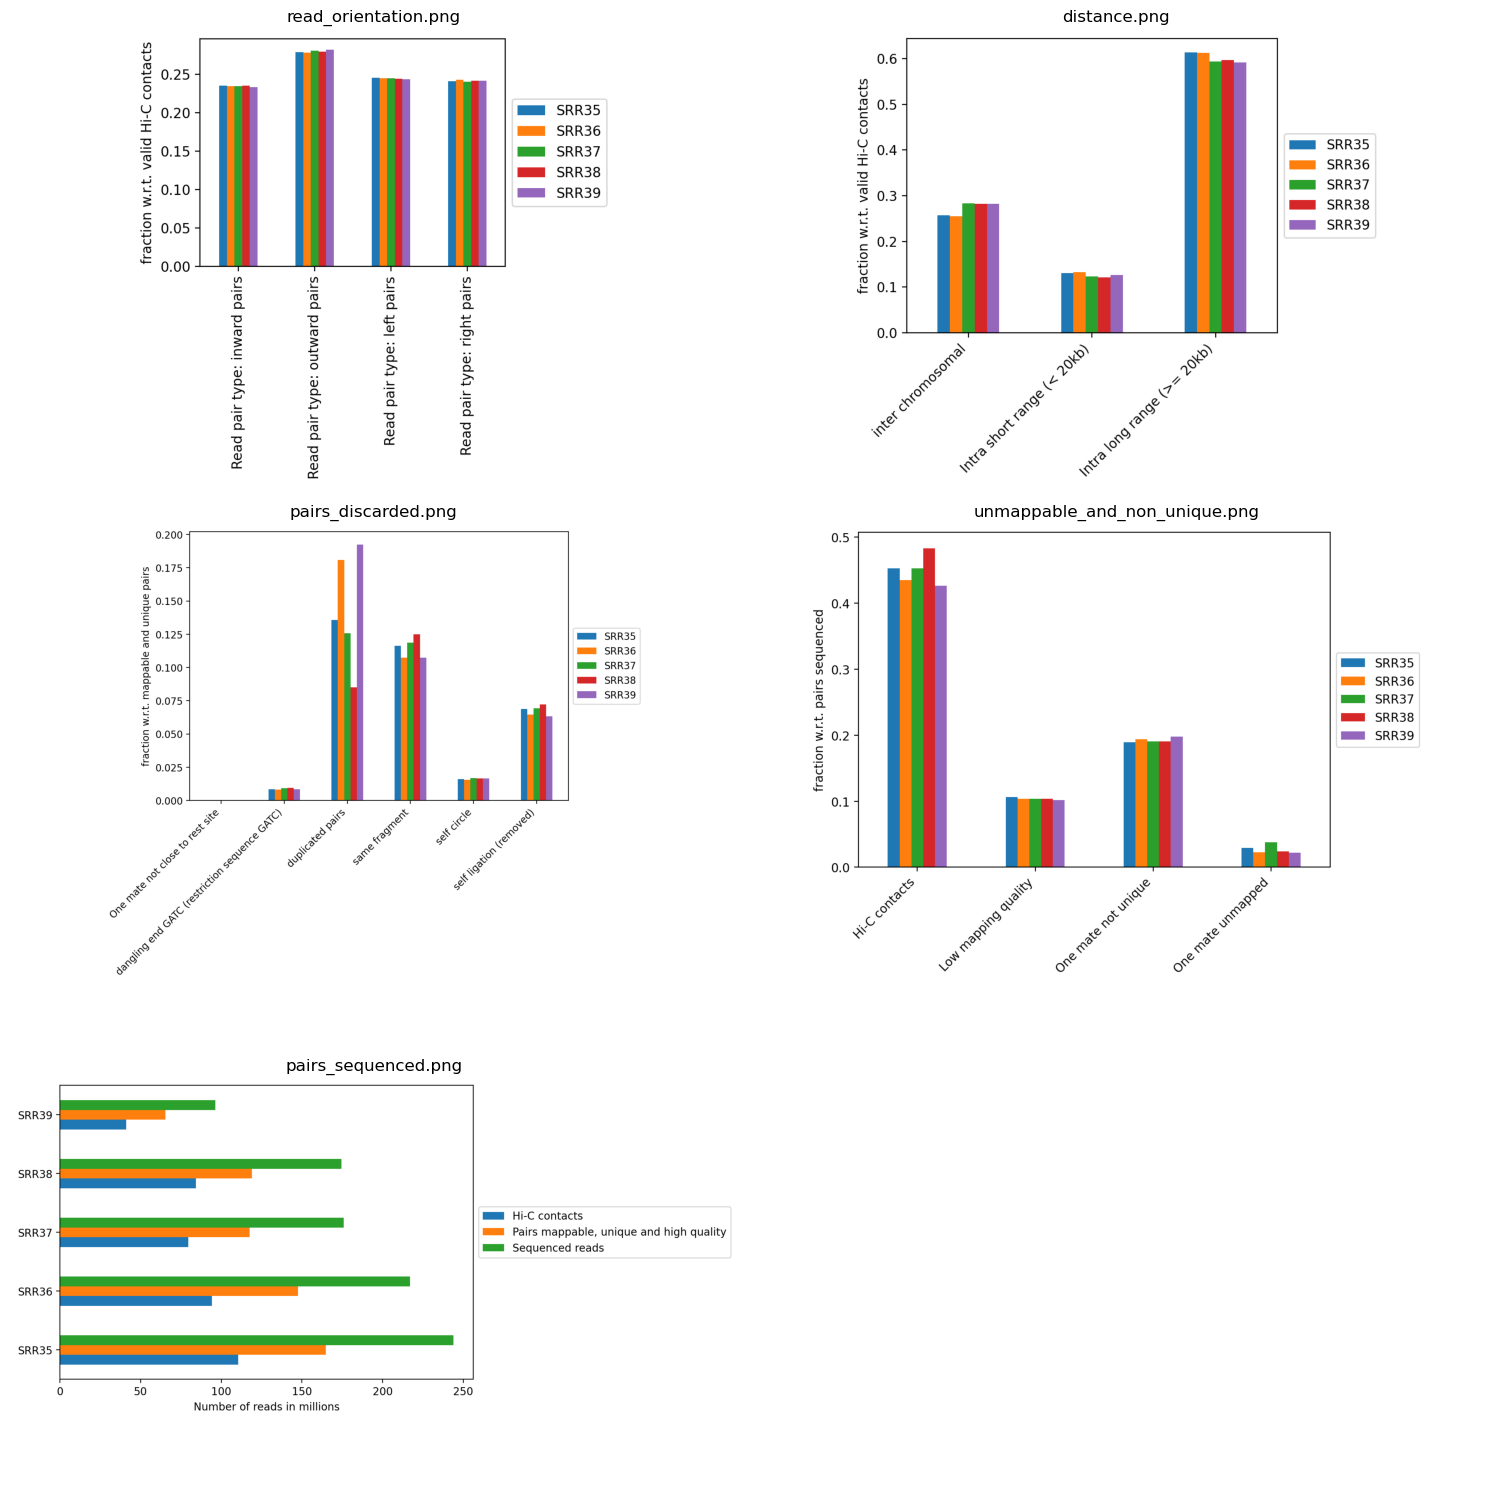

In [47]:
plot_pngs_in_grid("../steps/bwa/QC_all_samples/", ncol=2)

### Normalize matrices

In [14]:
%%bash 

hicNormalize -m ../steps/SRR6502335_matrix.h5 --normalize norm_range -o SRR6502335_norm0_1.h5

### Create a diagnostic plot

In [35]:
#! hicexplorer
! hicCorrectMatrix diagnostic_plot --help
#! hicCorrectMatrix correct --help

usage: hicCorrectMatrix diagnostic_plot --matrix hic_matrix.h5 -o file.png

options:
  -h, --help            show this help message and exit

Required arguments:
  --matrix MATRIX, -m MATRIX
                        Name of the Hi-C matrix to correct in .h5 format.
                        (default: None)
  --plotName PLOTNAME, -o PLOTNAME
                        File name to save the diagnostic plot. (default: None)

Optional arguments:
  --chromosomes CHROMOSOMES [CHROMOSOMES ...]
                        List of chromosomes to be included in the iterative
                        correction. The order of the given chromosomes will be
                        then kept for the resulting corrected matrix.
                        (default: None)
  --xMax XMAX           Max value for the x-axis in counts per bin. (default:
                        None)
  --perchr              Compute histogram per chromosome. For samples from
                        cells with uneven number of chromosomes an

Let's make a loop that produce a diagnostic plot for all matrices in the folder:

In [12]:
%%bash 

for FILE in ../steps/*.h5
do
echo $(basename $FILE _matrix.h5)_diag_plot.png
hicCorrectMatrix diagnostic_plot -m $FILE -o ../figures/$(basename $FILE _matrix.h5)_diag_plot.png
done

SRR6502335_diag_plot.png


INFO:hicexplorer.hicCorrectMatrix:Removing 7859 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.5428248511904763
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot SRR6502335_diag_plot.png



SRR6502336_diag_plot.png


INFO:hicexplorer.hicCorrectMatrix:Removing 7966 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.406856232876712
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot SRR6502336_diag_plot.png



SRR6502337_diag_plot.png


INFO:hicexplorer.hicCorrectMatrix:Removing 8187 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.5774256637168143
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot SRR6502337_diag_plot.png



SRR6502338_diag_plot.png


INFO:hicexplorer.hicCorrectMatrix:Removing 8172 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.689724621848739
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot SRR6502338_diag_plot.png



SRR6502339_diag_plot.png


INFO:hicexplorer.hicCorrectMatrix:Removing 8969 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.698
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot SRR6502339_diag_plot.png



Plotting all images in '../figures/bwa/*diag_plot.png'


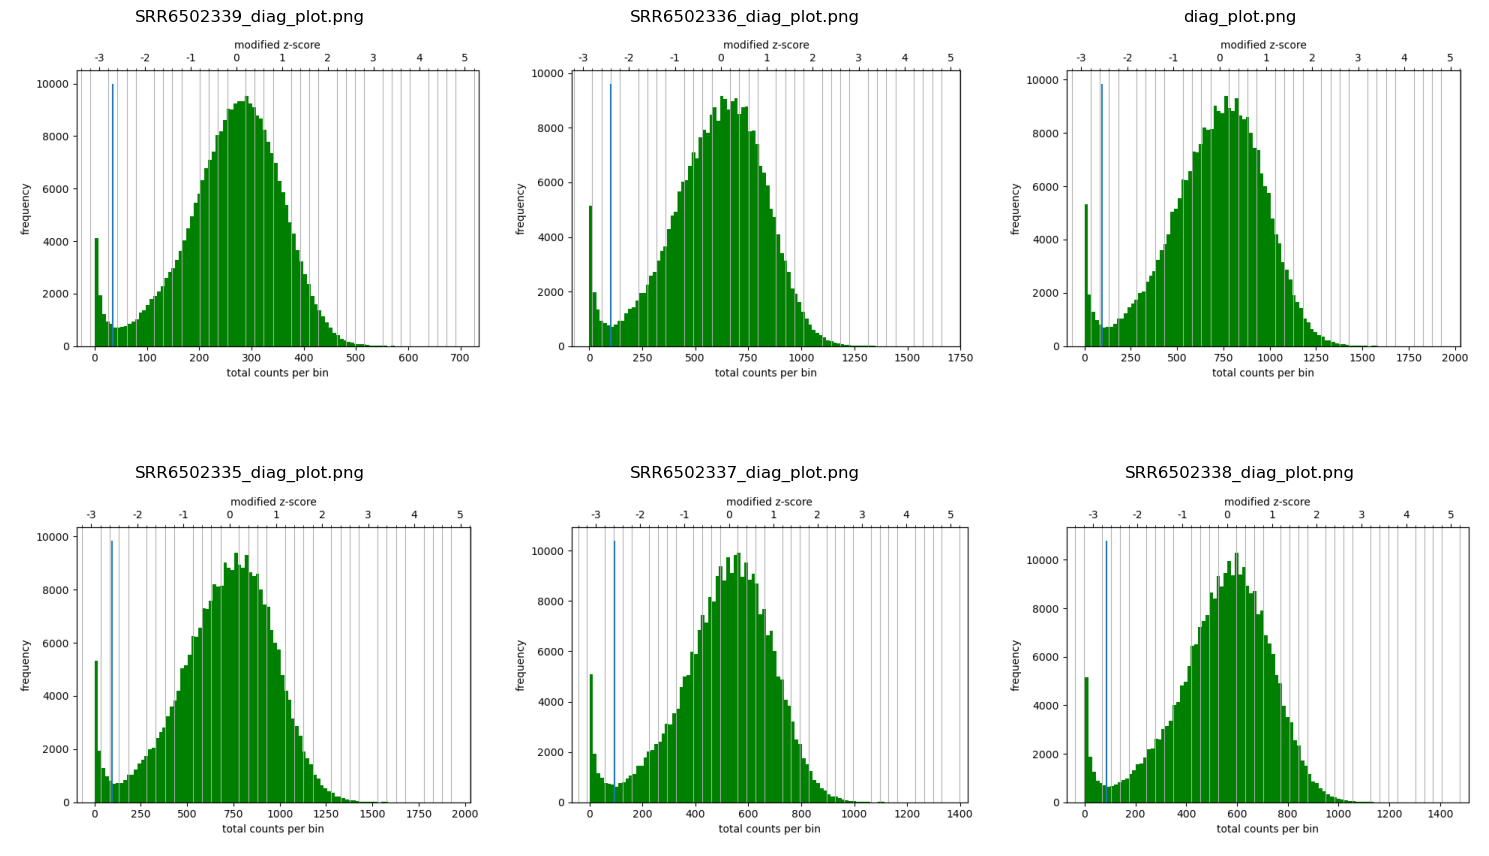

In [48]:
plot_pngs_in_grid("../figures/bwa", suffix="diag_plot.png")

In [15]:
!hicCorrectMatrix diagnostic_plot -m SRR6502335_norm0_1.h5 -o diag_plot_norm.png

INFO:hicexplorer.hicCorrectMatrix:Removing 13359 zero value bins
INFO:hicexplorer.hicCorrectMatrix:mad threshold -2.0545956094919804
INFO:hicexplorer.hicCorrectMatrix:Saving diagnostic plot diag_plot_norm.png



### Correct the matrices

And do the correction with the suggested values and ICE. We are going to produce a corrected matrix for both with and without `--perchr` (per chromosome) option

In [16]:
%%bash 

hicCorrectMatrix correct -m SRR6502335_norm0_1.h5 -o ./SRR6502335_norm0_1_corrected.h5 \
    --correctionMethod ICE \
    --filterThreshold -2 5

INFO:hicexplorer.hicCorrectMatrix:Removing 13359 zero value bins
INFO:hicexplorer.hicCorrectMatrix:matrix contains 21229234 data points. Sparsity 0.000.
INFO:hicexplorer.hicCorrectMatrix:filtering by z-score
INFO:hicexplorer.iterativeCorrection:starting iterative correction
INFO:hicexplorer.iterativeCorrection:pass 5 Estimated time 0:2:29
INFO:hicexplorer.iterativeCorrection:max delta - 1 = 0.909566849589952 
INFO:hicexplorer.iterativeCorrection:pass 10 Estimated time 0:2:27
INFO:hicexplorer.iterativeCorrection:max delta - 1 = 8.186419342166413 
INFO:hicexplorer.iterativeCorrection:pass 15 Estimated time 0:2:24
INFO:hicexplorer.iterativeCorrection:max delta - 1 = 0.8938109193741166 
INFO:hicexplorer.iterativeCorrection:pass 20 Estimated time 0:2:23
INFO:hicexplorer.iterativeCorrection:max delta - 1 = 7.228200439559446 
INFO:hicexplorer.iterativeCorrection:pass 25 Estimated time 0:2:22
INFO:hicexplorer.iterativeCorrection:max delta - 1 = 0.8790910335275449 
INFO:hicexplorer.iterativeCor

In [17]:
!hicInfo -m SRR6502335_norm0_1_corrected.h5

# Matrix information file. Created with HiCExplorer's hicInfo version 3.7.5
File:	SRR6502335_norm0_1_corrected.h5
Size:	298,615
Bin_length:	10000
Sum of matrix:	12588.40042256422
Chromosomes:length: NC_041754.1: 223616942 bp; NW_021160094.1: 26680 bp; NW_021160095.1: 32580 bp; NW_021160096.1: 33548 bp; NW_021160097.1: 37051 bp; NW_021160098.1: 39993 bp; NW_021160099.1: 40438 bp; NW_021160100.1: 43990 bp; NW_021160101.1: 48895 bp; NW_021160102.1: 50188 bp; NW_021160103.1: 51363 bp; NW_021160104.1: 35879 bp; NW_021160105.1: 54860 bp; NW_021160106.1: 55541 bp; NW_021160107.1: 55582 bp; NW_021160108.1: 59940 bp; NW_021160109.1: 82305 bp; NW_021160110.1: 118135 bp; NW_021160111.1: 133025 bp; NW_021160112.1: 52076 bp; NW_021160113.1: 116334 bp; NW_021160114.1: 65914 bp; NC_041755.1: 196197964 bp; NW_021160115.1: 30586 bp; NW_021160116.1: 35391 bp; NW_021160117.1: 40656 bp; NW_021160118.1: 51074 bp; NW_021160119.1: 48342 bp; NW_021160120.1: 52951 bp; NW_021160121.1: 86201 bp; NW_021160122.1: 

In [33]:
!hicMergeMatrixBins -m ../steps/SRR6502335_matrix.h5 -o SRR6502335_nb100 --numBins 100

In [20]:
# Plot chr1 (NC_041755.1)

!hicPlotMatrix -m SRR6502335_norm0_1_corrected.h5 -o SRR6502335_normcorrect_1.png --region NC_041755.1:0-105000000 --dpi 300

INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: False
INFO:hicexplorer.hicPlotMatrix:min: 3.59173195802721e-05, max: 0.06933028755391794



In [21]:
!hicPlotMatrix -m SRR6502335_norm0_1_corrected.h5 -o SRR6502335_normcorrect_x.png --region NC_041774.1:0-105000000 --log1p --dpi 300

INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: False
INFO:hicexplorer.hicPlotMatrix:min: 3.59173195802721e-05, max: 0.06933028755391794



## Results from `bowtie2 --end-to-end`

Let's look at the summary logs for each of the samples

In [10]:
SRR39 = HiCQCLog("../steps/bowtie2/SRR6502339_QC/QC.log")

In [38]:
import os
import pandas as pd
from IPython.display import display, HTML

# Define the base directory
base_dir = "../steps/bowtie2"

# List of sample directories (subfolders named SRR6502335_QC, SRR6502336_QC, ...)
sample_dirs = [f"SRR65023{n}_QC" for n in range(35, 40)]


# List of images to compare
image_filenames = [
    "distance.png",
    "pairs_discarded.png",
    "pairs_sequenced.png",
    "read_orientation.png",
    "unmappable_and_non_unique.png"
]

# Create an empty dictionary to hold the image paths for each sample
data = {sample: [] for sample in sample_dirs}

# Iterate over each sample folder and populate the paths for each image type
for sample_dir in sample_dirs:
    sample_path = os.path.join(base_dir, sample_dir)
    for image_filename in image_filenames:
        image_path = os.path.join(sample_path, image_filename)
        if os.path.exists(image_path):
            # Use HTML to display the image in a cell
            img_tag = f'<img src="{image_path}" width="400"/>'
            data[sample_dir].append(img_tag)
        else:
            data[sample_dir].append('Image not found')

# Create a DataFrame from the collected data
df = pd.DataFrame(data, index=image_filenames)

# Display the DataFrame as HTML in Jupyter notebook with images
display(HTML(df.to_html(escape=False)))


,SRR6502335_QC,SRR6502336_QC,SRR6502337_QC,SRR6502338_QC,SRR6502339_QC
distance.png,,,,,
pairs_discarded.png,,,,,
pairs_sequenced.png,,,,,
read_orientation.png,,,,,
unmappable_and_non_unique.png,,,,,


In [44]:
%%bash

# Use hicQC to compare:

(echo ../steps/bowtie2/*_QC/QC.log)

hicQC --logfiles $(echo ../steps/bowtie2/*_QC/QC.log) --labels "SRR35" "SRR36" "SRR37" "SRR38" "SRR39" --outputFolder ../steps/bowtie2/QC_all_samples


../steps/bowtie2/SRR6502335_QC/QC.log ../steps/bowtie2/SRR6502336_QC/QC.log ../steps/bowtie2/SRR6502337_QC/QC.log ../steps/bowtie2/SRR6502338_QC/QC.log ../steps/bowtie2/SRR6502339_QC/QC.log


Plotting all images in '../steps/bowtie2/QC_all_samples/*.png'


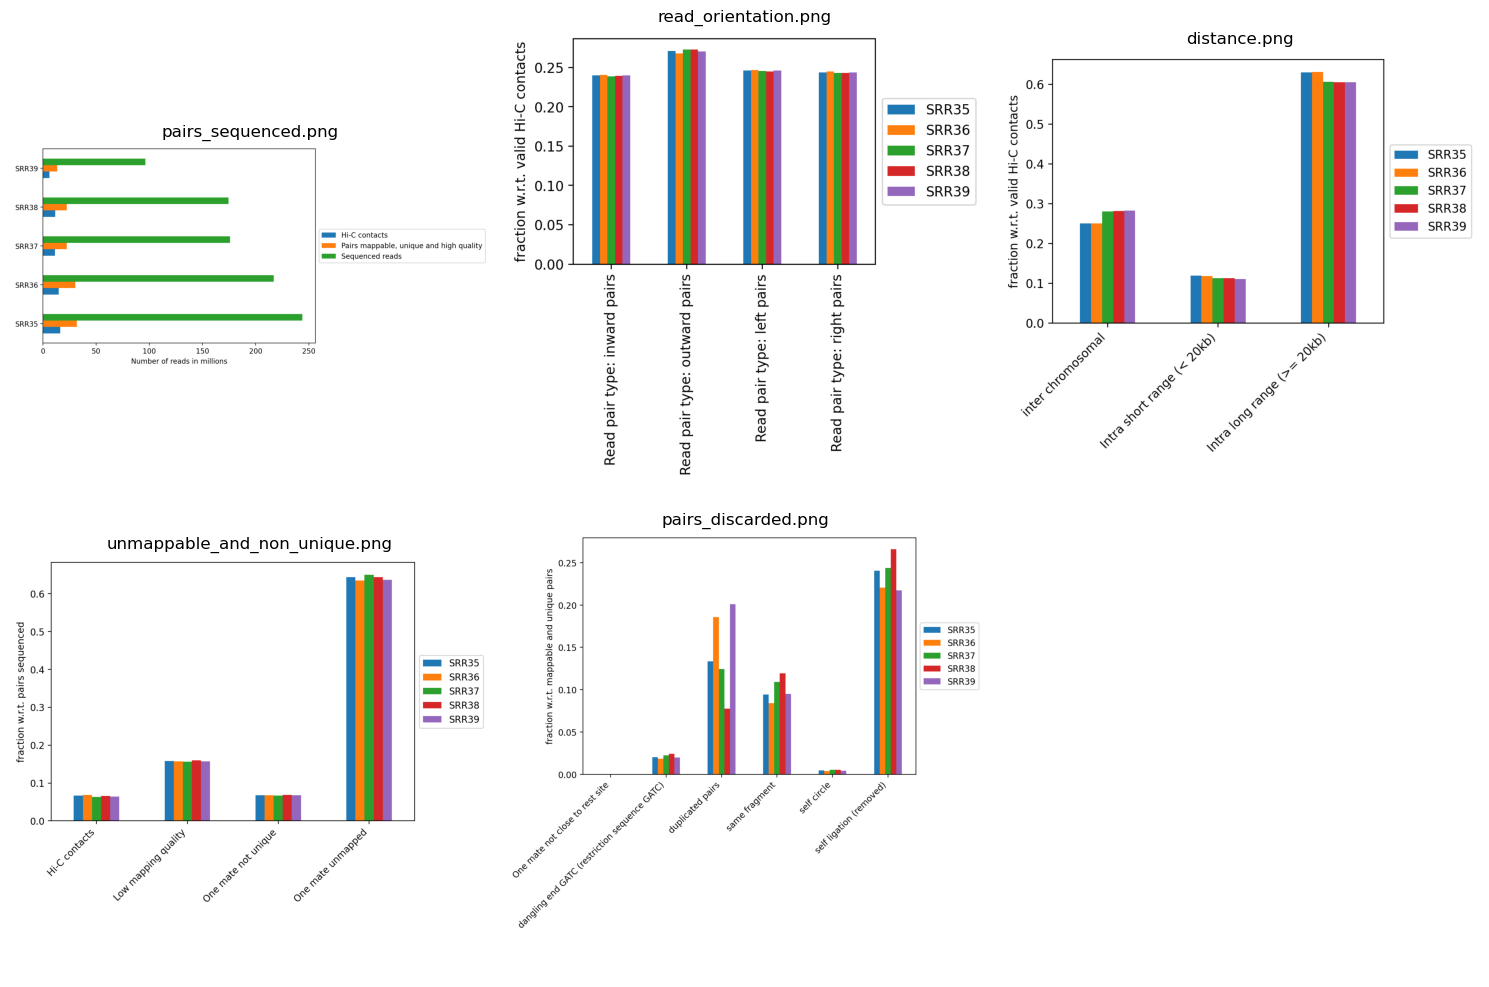

In [50]:
plot_pngs_in_grid("../steps/bowtie2/QC_all_samples/", ncol=3)

## Results from `bowtie2 --local`

In [52]:
%%bash

# Use hicQC to compare:

(echo ../steps/bowtie2/*_QC/QC.log)

hicQC --logfiles $(echo ../steps/bowtie2/local_mapping/*_QC/QC.log) --labels "SRR35" "SRR36" "SRR37" "SRR38" "SRR39" --outputFolder ../steps/bowtie2/local_mapping/QC_all_samples


../steps/bowtie2/SRR6502335_QC/QC.log ../steps/bowtie2/SRR6502336_QC/QC.log ../steps/bowtie2/SRR6502337_QC/QC.log ../steps/bowtie2/SRR6502338_QC/QC.log ../steps/bowtie2/SRR6502339_QC/QC.log


Plotting all images in '../steps/bowtie2/local_mapping/QC_all_samples/*.png'


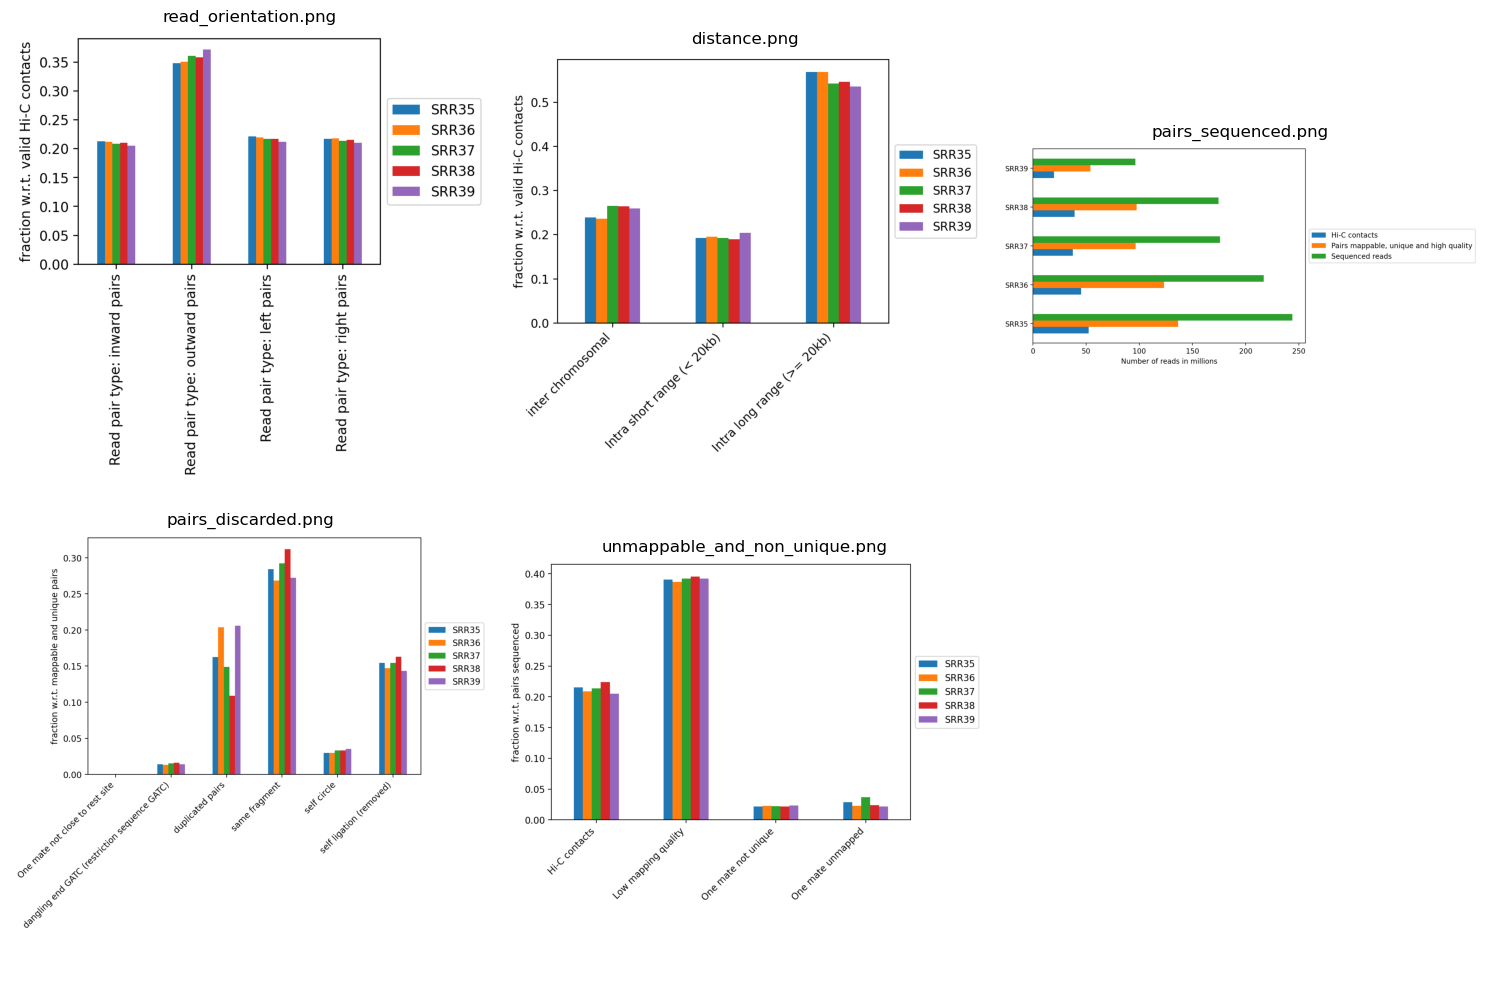

In [53]:
plot_pngs_in_grid("../steps/bowtie2/local_mapping/QC_all_samples/")

## Comparing QC results from all 3 mappings

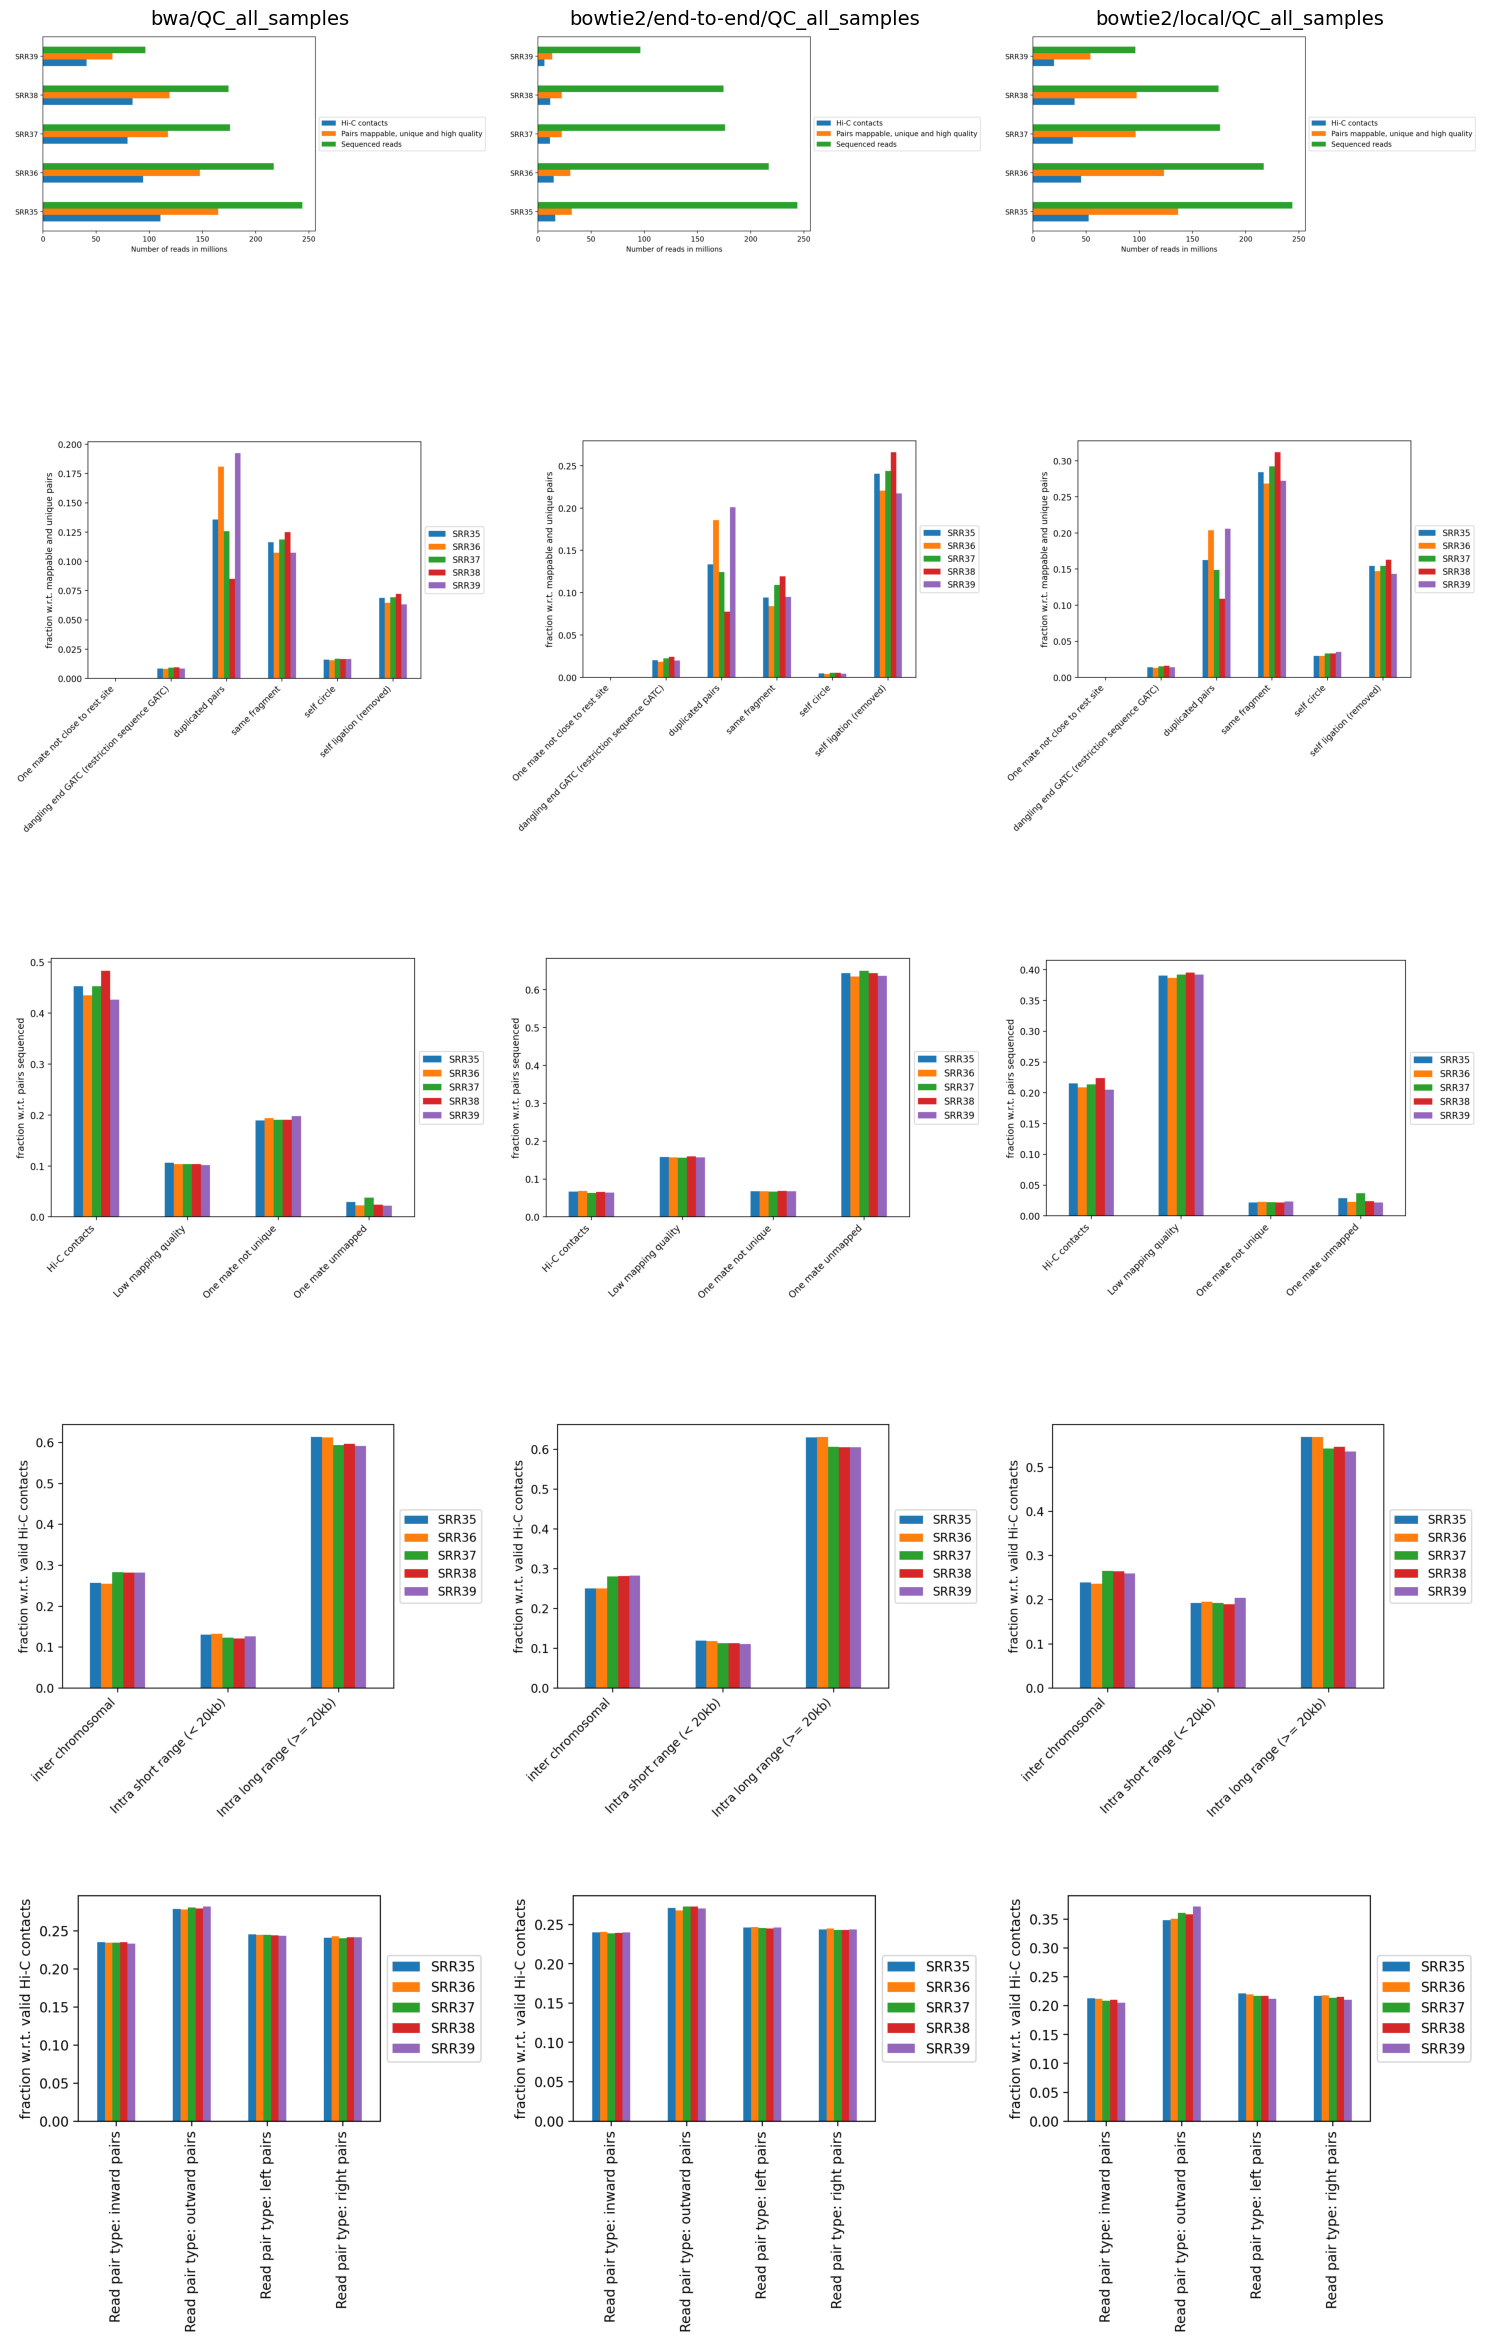

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the base directories for the different analyses
analyses_dirs = [
    '../steps/bwa/QC_all_samples',
    '../steps/bowtie2/end-to-end/QC_all_samples',
    '../steps/bowtie2/local/QC_all_samples'
]

# List of PNG files to compare (common to all analyses)
image_filenames = [
    "pairs_sequenced.png",
    "pairs_discarded.png",
    "unmappable_and_non_unique.png",
    "distance.png",
    "read_orientation.png"
]

# Number of rows (one per image type) and columns (one per analysis)
n_rows = len(image_filenames)
n_cols = len(analyses_dirs)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Plot each image in the corresponding subplot
for row, image_filename in enumerate(image_filenames):
    for col, analysis_dir in enumerate(analyses_dirs):
        image_path = os.path.join(analysis_dir, image_filename)
        if os.path.exists(image_path):
            img = mpimg.imread(image_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')  # Turn off axis labels
        else:
            axes[row, col].text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
        
        # Set the title for the first row
        if row == 0:
            #axes[row, col].set_title(os.path.basename(analysis_dir), fontsize=14)
            axes[row, col].set_title(analysis_dir.split("../steps/")[1], fontsize=14)

# Set row labels (for image types)
for row, image_filename in enumerate(image_filenames):
    axes[row, 0].set_ylabel(image_filename, fontsize=14, labelpad=20)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Filter the unplaced scaffolds from the mapping

In [10]:
!zcat "../data/links/ucsc_ref/rheMac10.fa.gz" | grep ">" | sed 's/>//' > all_chromosomes.txt

In [12]:
!grep -v "_" all_chromosomes.txt | sort -V > standard_chromosomes.txt

In [18]:
!cat standard_chromosomes.txt | tr '\n' ' ' > chromosome_order.txt

In [3]:
%%bash 

hicAdjustMatrix -m ../steps/bowtie2/local/SRR6502335.cool \
--outFileName filtered_SRR6502335.cool \
--chromosomes $(cat standard_chromosomes.txt | tr '\n' ' ')


In [7]:
# Check the reduction in size

!du -ha ../steps/bowtie2/local/*35.cool -d1

76M	../steps/bowtie2/local/filtered_SRR6502335.cool
80M	../steps/bowtie2/local/SRR6502335.cool


## Try to plot the new filtered matrix

First, check the info on the cooler

In [9]:
!hicInfo -m ../steps/bowtie2/local/filtered_SRR6502335.cool

# Matrix information file. Created with HiCExplorer's hicInfo version 3.7.5
File:	../steps/bowtie2/local/filtered_SRR6502335.cool
Date:	2024-09-24T12:08:51.357930
Genome assembly:	unknown
Size:	285,408
Bin_length:	10000
Chromosomes:length: chr1: 223616942 bp; chr2: 196197964 bp; chr3: 185288947 bp; chr4: 169963040 bp; chr5: 187317192 bp; chr6: 179085566 bp; chr7: 169868564 bp; chr8: 145679320 bp; chr9: 134124166 bp; chr10: 99517758 bp; chr11: 133066086 bp; chr12: 130043856 bp; chr13: 108737130 bp; chr14: 128056306 bp; chr15: 113283604 bp; chr16: 79627064 bp; chr17: 95433459 bp; chr18: 74474043 bp; chr19: 58315233 bp; chr20: 77137495 bp; chrM: 16564 bp; chrX: 153388924 bp; chrY: 11753682 bp; 
Number of chromosomes:	23
Non-zero elements:	36,751,866
The following columns are available: ['chrom' 'start' 'end']


Generated by:	HiCMatrix-17.2
Cooler library version:	cooler-0.10.2
HiCMatrix url:	https://github.com/deeptools/HiCMatrix



In [10]:
# Apparently, something went wrong when creating the different binSizes with hicBuildMatrix, so we will create and merge them manually (.mcool)

!hicMergeMatrixBins --help

usage: hicMergeMatrixBins --matrix matrix.h5 --outFileName OUTFILENAME
                          --numBins int [--runningWindow] [--help] [--version]

Merges bins from a Hi-C matrix. For example, using a matrix containing 5kb
bins, a matrix of 50kb bins can be derived using --numBins 10. From one type
of downstream analysis to another, different bin sizes are used. For example
to call TADs, unmerged matrices are recommended while to display Hi-C
matrices, bins of approximately 2000bp usually yield the best representations
with `hicPlotMatrix` for small regions, and even larger bins (50kb) are
recommended for whole chromosome representations or for `hicPlotDistVsCounts`.

Required arguments:
  --matrix matrix.h5, -m matrix.h5
                        Matrix to reduce in h5 format. (default: None)
  --outFileName OUTFILENAME, -o OUTFILENAME
                        File name to save the resulting matrix. The output is
                        also a .h5 file. But don't add the suffix. (defa

### Merge bins from the raw matrix

In [11]:
!hicMergeMatrixBins -m ../steps/bowtie2/local/matrices/SRR6502335.cool -o ../steps/bowtie2/local/matrices/SRR6502335_50kb.cool -nb 5

In [19]:
!hicMergeMatrixBins -m ../steps/bowtie2/local/matrices/SRR6502335.cool -o ../steps/bowtie2/local/matrices/SRR6502335_100kb.cool -nb 10

### Merge bins from the filtered matrix

In [ ]:
!hicMergeMatrixBins -m ../steps/bowtie2/local/matrices/filtered_SRR6502335.cool -o ../steps/bowtie2/local/matrices/filtered_SRR6502335_50kb.cool -nb 5

In [22]:
!hicInfo -m ../steps/bowtie2/local/matrices/filtered_SRR6502335_50kb.cool

# Matrix information file. Created with HiCExplorer's hicInfo version 3.7.5
File:	../steps/bowtie2/local/matrices/filtered_SRR6502335_50kb.cool
Date:	2024-09-24T15:52:47.957236
Genome assembly:	unknown
Size:	56,325
Chromosomes:length: chr1: 223616942 bp; chr2: 196190000 bp; chr3: 185270000 bp; chr4: 169963040 bp; chr5: 187280000 bp; chr6: 179085566 bp; chr7: 169850000 bp; chr8: 145679320 bp; chr9: 134110000 bp; chr10: 99517758 bp; chr11: 133066086 bp; chr12: 130040000 bp; chr13: 108730000 bp; chr14: 128040000 bp; chr15: 113283604 bp; chr16: 79627064 bp; chr17: 95410000 bp; chr18: 74460000 bp; chr19: 58310000 bp; chr20: 77137495 bp; chrX: 153380000 bp; chrY: 11250000 bp; 
Number of chromosomes:	22
Non-zero elements:	24,159,441
The following columns are available: ['chrom' 'start' 'end']


Generated by:	HiCMatrix-17.2
Cooler library version:	cooler-0.10.2
HiCMatrix url:	https://github.com/deeptools/HiCMatrix



In [10]:
!hicMergeMatrixBins -m ../steps/bowtie2/local/matrices/filtered_SRR6502335.cool -o ../steps/bowtie2/local/matrices/filtered_SRR6502335_100kb.cool -nb 10

### Create plots (each chromosome separately) and compare filtered vs unfiltered matrices

In [13]:
%%bash 

for CHR in $(cat standard_chromosomes.txt)
do 
    echo $CHR
    hicPlotMatrix -m ../steps/bowtie2/local/matrices/SRR6502335_50kb.cool --chromosomeOrder $CHR -o ../figures/bowtie2/local/raw_50kb_$CHR.png --dpi 200
    hicPlotMatrix -m ../steps/bowtie2/local/matrices/filtered_SRR6502335_50kb.cool --chromosomeOrder $CHR -o ../figures/bowtie2/local/raw_filter_50kb_$CHR.png --dpi 200
done

chr1


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr2


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr3


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr4


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr5


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr6


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr7


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr8


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr9


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr10


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr11


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr12


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr13


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr14


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr15


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr16


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr17


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr18


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr19


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr20


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chrX


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chrY


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


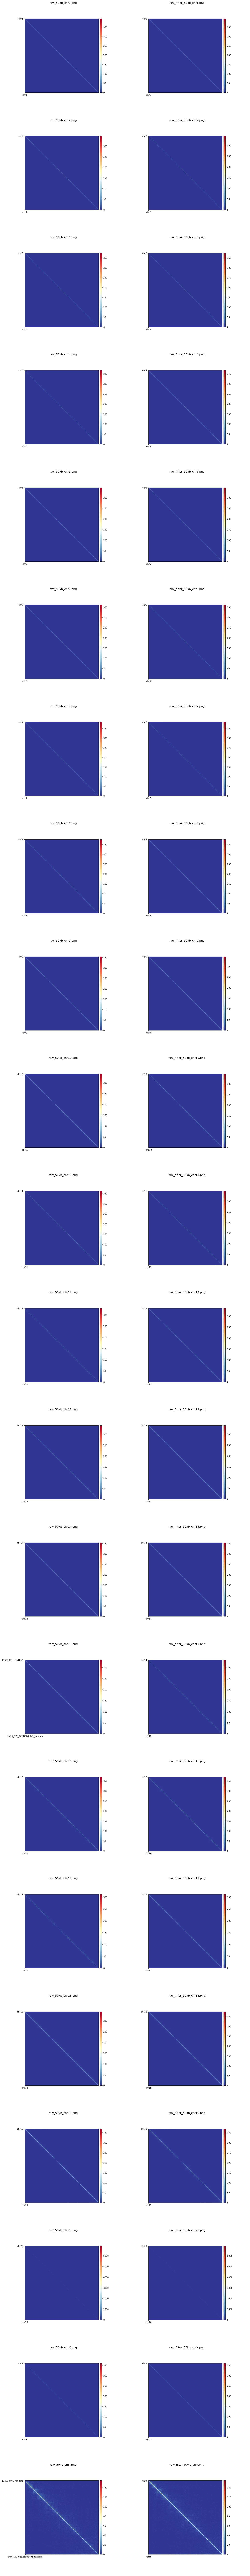

In [19]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Directory containing the PNG files
directory = '../figures/bowtie2/local/'

# List all raw_chr* files
raw_files = [f for f in os.listdir(directory) if f.startswith('raw_50kb') and f.endswith('.png')]

# List all raw_filter_chr* files
raw_filter_files = [f for f in os.listdir(directory) if f.startswith('raw_filter_50kb') and f.endswith('.png')]

# Sort files using natural sorting
sorted_raw_files = natsorted(raw_files)
sorted_raw_filter_files = natsorted(raw_filter_files)

paired_files = list(zip(sorted_raw_files, sorted_raw_filter_files))

# Plot the images side by side
num_pairs = len(paired_files)
fig, axes = plt.subplots(num_pairs, 2, figsize=(15, 7 * num_pairs))

for i, (raw_file, raw_filter_file) in enumerate(paired_files):
    # Plot raw image
    raw_img_path = os.path.join(directory, raw_file)
    raw_img = plt.imread(raw_img_path)
    axes[i, 0].imshow(raw_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(raw_file)

    # Plot raw_filter image
    raw_filter_img_path = os.path.join(directory, raw_filter_file)
    raw_filter_img = plt.imread(raw_filter_img_path)
    axes[i, 1].imshow(raw_filter_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(raw_filter_file)

plt.tight_layout()
plt.show()

## Pooled samples

### Pool the samples (matrices) into one big matrix

In [9]:
%%bash

# Check the sizes of the (unmodified, 10kb binned) matrices
hicInfo -m ../steps/bowtie2/local/matrices/SRR650233{5..9}.cool \
    | grep -E "File|Size" \
    | awk '/File/ {print; next} /Size/ {print $0 "\n"}'

File:	../steps/bowtie2/local/matrices/SRR6502335.cool
Size:	298,615

File:	../steps/bowtie2/local/matrices/SRR6502336.cool
Size:	298,615

File:	../steps/bowtie2/local/matrices/SRR6502337.cool
Size:	298,615

File:	../steps/bowtie2/local/matrices/SRR6502338.cool
Size:	298,615

File:	../steps/bowtie2/local/matrices/SRR6502339.cool
Size:	298,615



In [31]:
!hicSumMatrices -m $(echo ../steps/bowtie2/local/matrices/SRR650233{5..9}.cool) -o ../steps/bowtie2/local/matrices/pooled_10kb.cool

In [12]:
%%bash 

hicAdjustMatrix -m ../steps/bowtie2/local/matrices/pooled_10kb.cool \
    --outFileName filtered_pooled_10kb.cool \
    --chromosomes $(cat chromosome_order.txt)

In [16]:
!hicInfo -m ../steps/bowtie2/local/matrices/pooled_10kb.cool | grep -E 'File|Size|Number|Non'
!echo ""
!hicInfo -m ../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool | grep -E 'File|Size|Number|Non'

File:	../steps/bowtie2/local/matrices/pooled_10kb.cool
Size:	298,615
Number of chromosomes:	2939
Non-zero elements:	117,537,653

File:	../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool
Size:	285,406
Number of chromosomes:	22
Non-zero elements:	117,090,191


### Create different bin sizes (`hicMergeMatrixBins`)

In [17]:
%%bash 

hicMergeMatrixBins \
    -m ../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool \
    -o ../steps/bowtie2/local/matrices/filtered_pooled_50kb.cool \
    -nb 5 

hicMergeMatrixBins \
    -m ../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool \
    -o ../steps/bowtie2/local/matrices/filtered_pooled_100kb.cool \
    -nb 10


In [25]:
%%bash
hicInfo -m ../steps/bowtie2/local/matrices/filtered_pooled_{10,50,100}kb.cool \
    | grep -E 'File|Size|Number|Non' \
    | sed '/Non/a\\'

File:	../steps/bowtie2/local/matrices/filtered_pooled_10kb.cool
Size:	285,406
Number of chromosomes:	22
Non-zero elements:	117,090,191

File:	../steps/bowtie2/local/matrices/filtered_pooled_50kb.cool
Size:	56,129
Number of chromosomes:	22
Non-zero elements:	73,496,938

File:	../steps/bowtie2/local/matrices/filtered_pooled_100kb.cool
Size:	28,066
Number of chromosomes:	22
Non-zero elements:	55,337,833



### Plot the chromosomes (seperately)

In [28]:
%%bash 

for CHR in $(cat standard_chromosomes.txt)
do 
    echo $CHR
    hicPlotMatrix -m ../steps/bowtie2/local/matrices/filtered_pooled_50kb.cool --chromosomeOrder $CHR -o ../figures/bowtie2/local/filter_pooled_50kb_$CHR.png --dpi 200
done

chr1


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr2


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr3


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr4


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr5


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr6


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr7


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr8


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr9


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr10


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr11


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr12


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr13


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr14


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr15


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr16


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr17


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr18


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr19


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chr20


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chrX


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


chrY


INFO:hicexplorer.hicPlotMatrix:Cooler or no cooler: True


Plotting all images in '../figures/bowtie2/local/*filter_pooled_50kb_*':
['../figures/bowtie2/local/filter_pooled_50kb_chr1.png', '../figures/bowtie2/local/filter_pooled_50kb_chr2.png', '../figures/bowtie2/local/filter_pooled_50kb_chr3.png', '../figures/bowtie2/local/filter_pooled_50kb_chr4.png', '../figures/bowtie2/local/filter_pooled_50kb_chr5.png', '../figures/bowtie2/local/filter_pooled_50kb_chr6.png', '../figures/bowtie2/local/filter_pooled_50kb_chr7.png', '../figures/bowtie2/local/filter_pooled_50kb_chr8.png', '../figures/bowtie2/local/filter_pooled_50kb_chr9.png', '../figures/bowtie2/local/filter_pooled_50kb_chr10.png', '../figures/bowtie2/local/filter_pooled_50kb_chr11.png', '../figures/bowtie2/local/filter_pooled_50kb_chr12.png', '../figures/bowtie2/local/filter_pooled_50kb_chr13.png', '../figures/bowtie2/local/filter_pooled_50kb_chr14.png', '../figures/bowtie2/local/filter_pooled_50kb_chr15.png', '../figures/bowtie2/local/filter_pooled_50kb_chr16.png', '../figures/bowtie2/loc

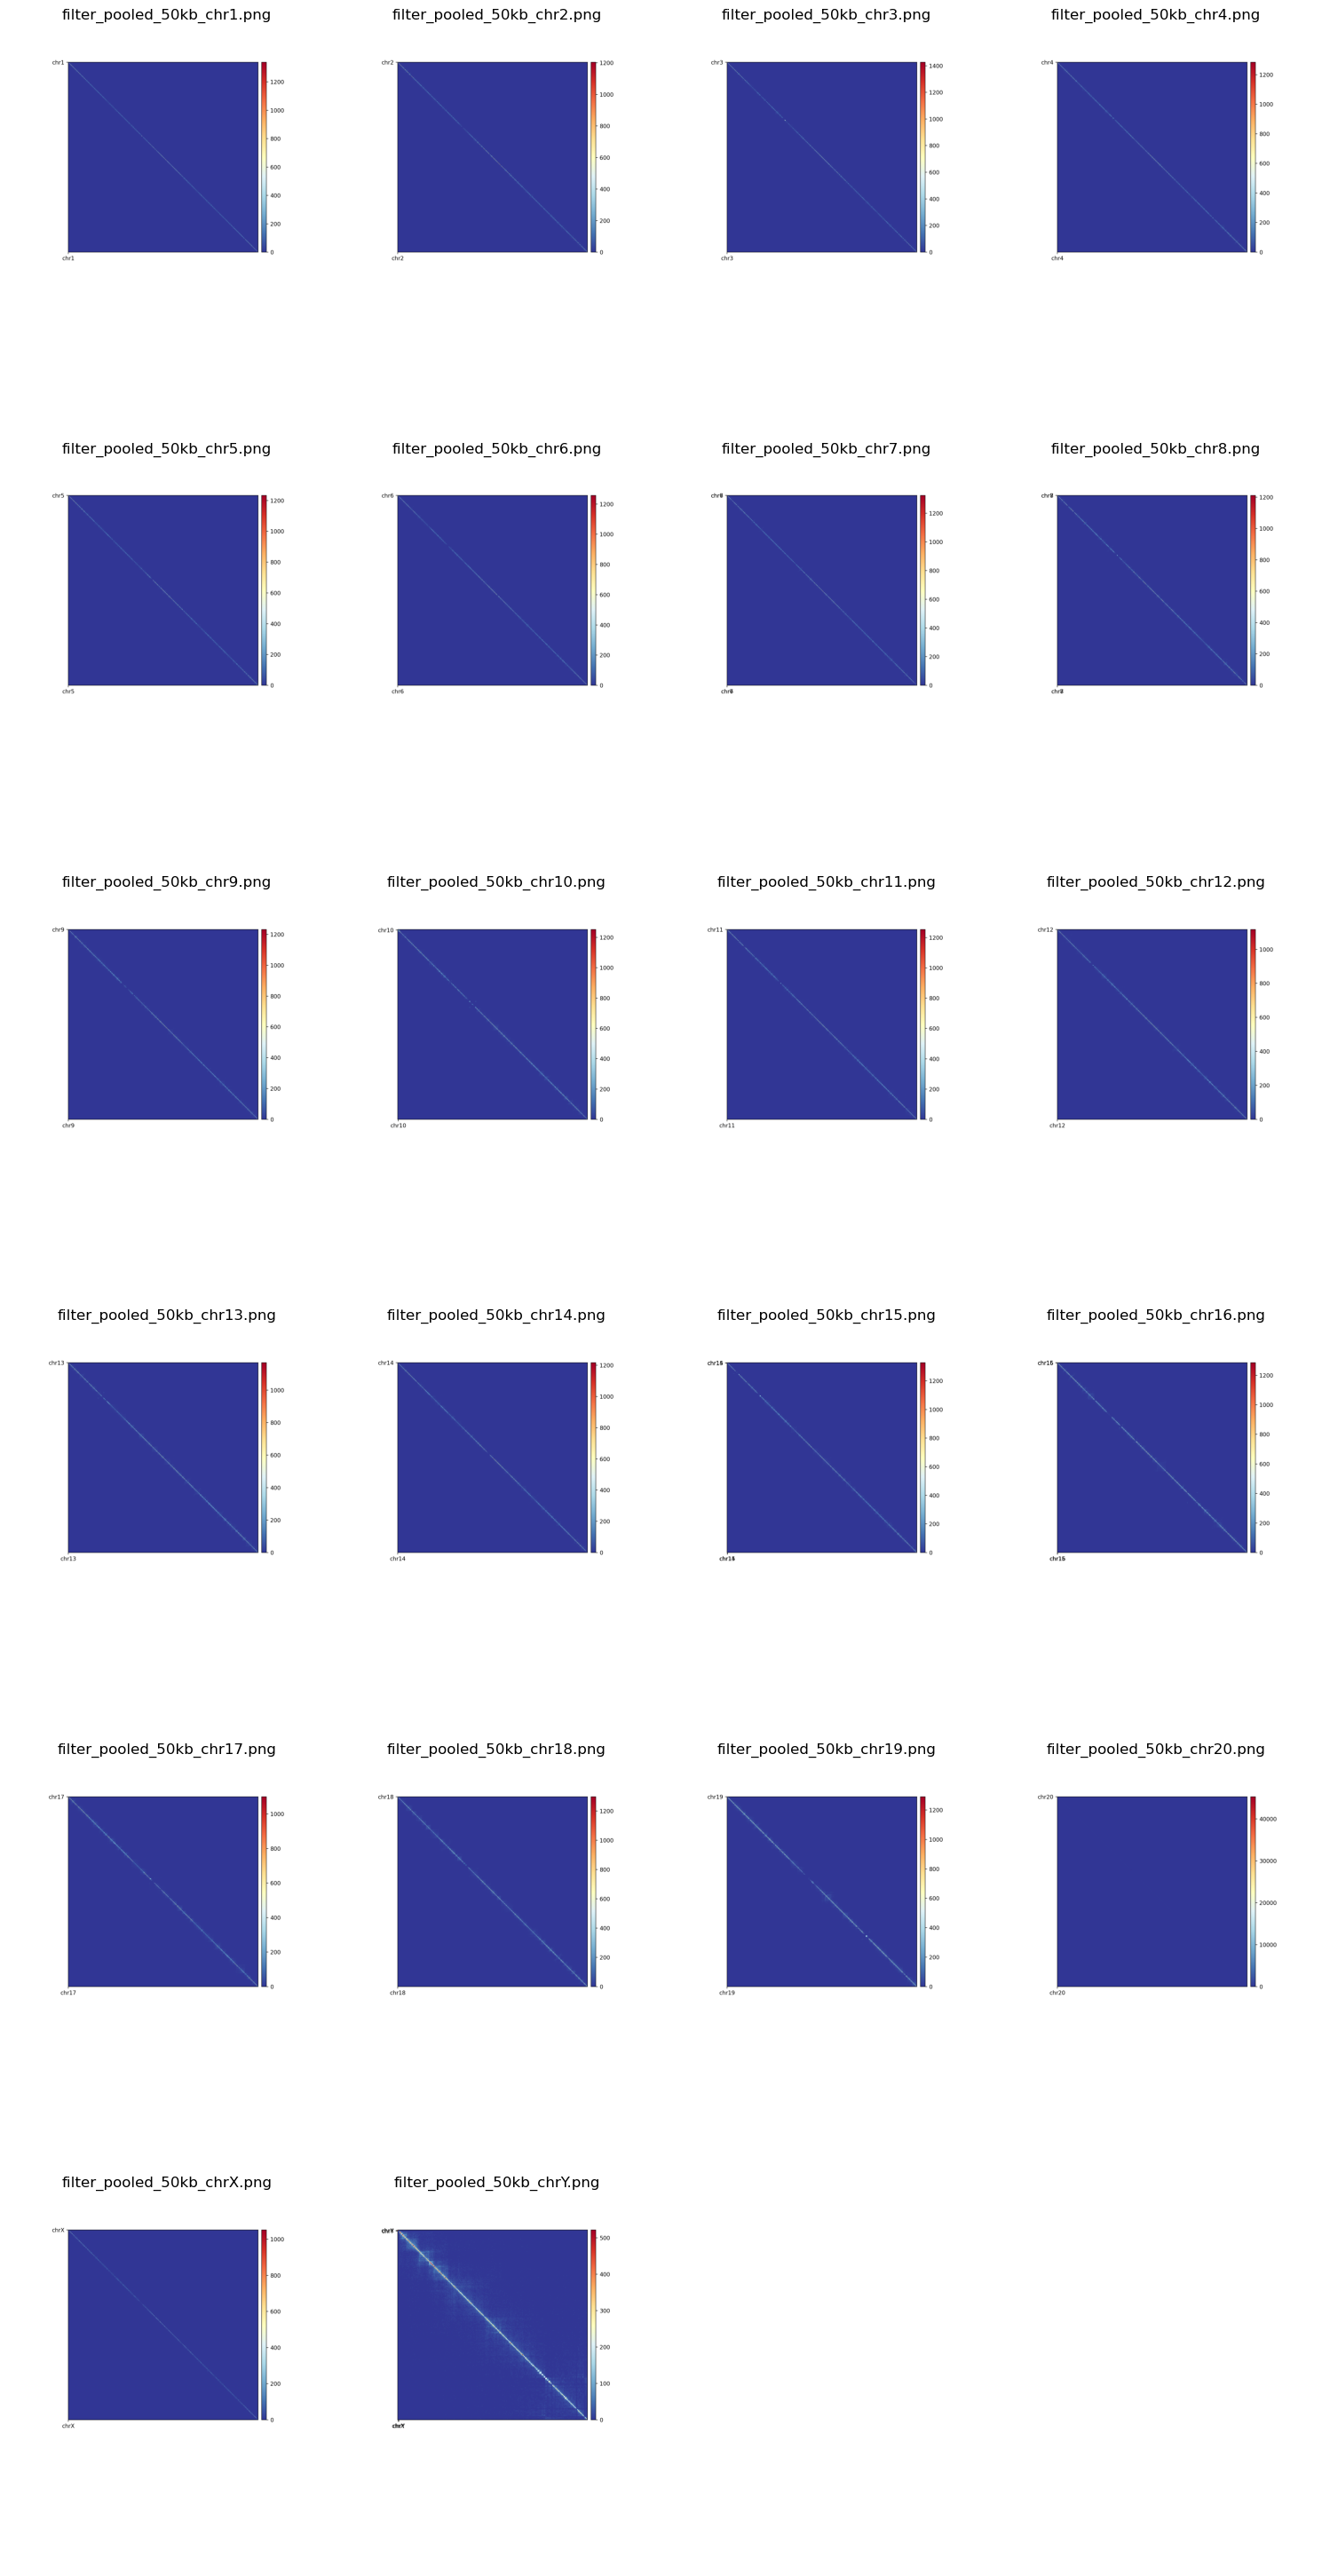

In [29]:
from hicstuff import plot_pngs_in_grid as plt

plt("../figures/bowtie2/local/", suffix="filter_pooled_50kb_*", ncol=4)